# Tarea 3: Regularización y Optimización <br/> CC6204 Deep Learning, Universidad de Chile  <br/> Hoja de respuestas
## Nombre: Guillermo Martínez

**Fecha de entrega: 21 de noviembre de 2020**


In [ ]:
# Este notebook está pensado para correr en CoLaboratory. 
# Lo único imprescindible por importar es torch
import torch

# Posiblemenete quieras instalar e importar ipdb para debuggear.
# Si es así, descomenta lo siguiente:
# !pip install -q ipdb
# import ipdb

# Aqui instalamos la libreria de correccion del curso
!pip install -U "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"
from timeit import default_timer as timer

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-3yfb57dz/cc6204
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-3yfb57dz/cc6204
  Created wheel for cc6204: filename=cc6204-0.5.0-cp36-none-any.whl size=5801 sha256=b20c2531f8c78bb01f278d9c63c1a00c09959bde35c1c55edf7a893daaffe2a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-yq8w_h3b/wheels/62/f0/30/aadcb7ce24a2f9c935890518e902d4e23bf97b80f47bb64414
Successfully built cc6204
  Found existing installation: cc6204 0.5.0
    Uninstalling cc6204-0.5.0:
      Successfully uninstalled cc6204-0.5.0


In [ ]:
# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# ingresa el host y port que posteamos en u-cursos
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# anota el token que te daremos en u-cursos
token = "]ye/Ox;nsz"

Connection stablished


# Parte 1: Regularización y Generalización



## 1a) Regularización por *weight decay*

In [ ]:
class SGD():
  
  def __init__(self, parameters, lr, beta):
    self.params = [p for p in parameters if p is not None]
    self.lr = lr
    self.beta = beta
  
  def step(self):
    for p in self.params:
      if p.dim() > 1:
        p_r = p.data.clone()
        p.data = p_r*(1 - self.beta) - p.grad * self.lr
      else:
        p.data -= p.grad * self.lr

In [ ]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="1a", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = SGD([weight], lr=0.1, beta=0.1)
optimizer.step()

# Submit
corrector.submit(homework=3, question="1a", test=1, token=token, answer=weight)

Correct Test!


## 1b) Regularización por dropout

Para esta parte de la tarea, va a ser necesario modificar el método `forward` para que entregue el valor a la salida de la i-esima capa escondida. Para esto se modifica el método forward para que reciba un parámetro `output_layer` que indica luego de que capa escondida se espera el output.

In [ ]:
# Funciones de activación y sus gradientes

def sig(T, gradient=False):
  if gradient:
    sigT = sig(T)
    return sigT * (1 - sigT)
  return torch.reciprocal(1 + torch.exp(-1 * T))
  
def tanh(T, gradient=False):
  if gradient:
    tanhT = tanh(T)
    return 1 - tanhT * tanhT
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

def relu(T, gradient=False):
  if gradient:
    outT = torch.zeros_like(T)
    outT[T>=0] = 1
    return outT
  return torch.max(T, torch.zeros_like(T))

def swish(T, beta=1, gradient=False):
  if gradient:
    sigbT = sig(beta * T)
    swishT = T * sigbT
    return sigbT + beta * swishT * (1 - sigbT), swishT * (T - swishT)
  return T * torch.reciprocal(1 + torch.exp(-beta * T))

def celu(T, alpha=1, gradient=False):
  if alpha == 0:
    raise ValueError("alpha cannot be 0")

  zeros = torch.zeros_like(T)
  Talpha = T / alpha
  
  if gradient:
    e = Talpha.exp()
    d_dx = torch.ones_like(T)
    d_dx[T<0] = e[T<0]
    zeros[T<0] = (celu(T)[T<0] - T[T<0] * e[T<0]) / alpha
    return d_dx, zeros # d_dx, d_da
  
  return torch.max(zeros, T) + torch.min(zeros, alpha * (Talpha).expm1())

def softmax(T, dim, estable=True):
  if estable:
    T -= T.max(dim=dim, keepdim=True)[0]  # keepdim=True => output has dim with size 1. Otherwise, dim is squeezed
  exp = torch.exp(T)
  return exp / torch.sum(exp, dim=dim, keepdim=True)  # keepdim=True => output has dim with size 1. Otherwise, dim is squeezed

In [ ]:
def get_init_weights(shape):
  W = torch.randn(shape)
  return torch.nn.Parameter(W)


def create_dropout_mask(x, prob):
    m = torch.distributions.Bernoulli(torch.tensor([prob]))
    mask = torch.div(m.sample(sample_shape=torch.Size([1,x.shape[1]])).view(-1,x.shape[1]).repeat(x.shape[0], 1), prob)
    return mask


class FFNN(torch.nn.Module):
  
  def __init__(self, F, l_h, l_a, C, keep_prob, l_a_params=None):
    super(FFNN, self).__init__()
       
    sizes = [F] + l_h + [C]
    self.Ws = torch.nn.ParameterList([get_init_weights((sizes[i], sizes[i+1])) for i in range(len(sizes)-1)])
    self.bs = torch.nn.ParameterList([torch.nn.Parameter(torch.zeros(h)) for h in sizes[1:]])
    self.fs = l_a
    self.keep_prob = keep_prob
    if l_a_params is not None:
      self.fs_ps_mask = [torch.nn.Parameter(torch.tensor(p)) if p else None for p in l_a_params]
    else:
      self.fs_ps_mask = [None for _ in l_a]
    self.fs_ps = torch.nn.ParameterList([p for p in self.fs_ps_mask if p])
    
  @property
  def in_size(self):
    return self.Ws[0].shape[0]
    
  def load_weights(self, Ws, U, bs, c):
    self.Ws = torch.nn.ParameterList([torch.nn.Parameter(W) for W in Ws + [U]])
    self.bs = torch.nn.ParameterList([torch.nn.Parameter(b) for b in bs + [c]])
  
  def resumen(self):
    for name, p in self.named_parameters():
      print('{}:\t{}'.format(name, p.size()))
    pass
  
  def forward(self, x, predict=False, output_layer=-1):
    self.cacheU = [] #, self.cacheH = [], []
    self.cacheM = []
    
    if predict:
      original_prob = self.keep_prob
      for i in range(len(self.keep_prob)):
        self.keep_prob[i] = 1.0
    
    counter = 0
    mask = create_dropout_mask(x, self.keep_prob[counter])
    if (x.is_cuda):
      mask = mask.to('cuda')
    self.cacheM.append(mask)
    x = torch.mul(x,mask)

    for W, b, f, p in zip(self.Ws[:-1], self.bs[:-1], self.fs, self.fs_ps_mask):
      x = torch.mm(x, W) + b
      self.cacheU.append(x)
      x = f(x, p.item()) if p else f(x)

      mask = create_dropout_mask(x, self.keep_prob[counter + 1])
      if (x.is_cuda):
        mask = mask.to('cuda')
      self.cacheM.append(mask)
      x = torch.mul(x,mask)

      # for the output_layer test
      if counter == output_layer:
        return x
      counter += 1

    return softmax(torch.mm(x, self.Ws[-1]) + self.bs[-1], dim=1)
  
  def backward(self, x, y, y_pred):
    current_grad =  (y_pred - y) / y.size(0)
    
    for i in range(len(self.Ws)-1, 0, -1):
      if self.fs_ps_mask[i-1] is None:
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1]).t() @ current_grad
      else:
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps_mask[i-1].item()).t()  @ current_grad
      self.bs[i].grad = current_grad.sum(dim=0)
      h_grad = torch.mul(current_grad @ self.Ws[i].t(), self.cacheM[i])

      if self.fs_ps_mask[i-1] is None:
        current_grad = self.fs[i-1](self.cacheU[i-1], gradient=True) * h_grad
      else:
        current_grad, p_grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps_mask[i-1], gradient=True)
        current_grad *= h_grad
        self.fs_ps_mask[i-1].grad = (p_grad * h_grad).sum()
    
    self.Ws[0].grad = x.t() @ current_grad
    self.bs[0].grad = current_grad.sum(dim=0)

In [ ]:
# Tests del API del curso
torch.manual_seed(0)
sample = torch.rand(1, 10)
red = FFNN(10, [1000], [sig], 1, keep_prob=[1.0, 0.5])
y = red(sample, output_layer=0)
output_mask = (y == 0)
percent = torch.sum(output_mask).item() / list(output_mask.size())[-1]
print(percent)

# Submit
corrector.submit(homework=3, question="1b", test=1, token=token, answer=percent)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


0.528
Correct Test!


## 1c) Entrenamiento y generalización sobre MNIST 

In [ ]:
# Aqui el codigo para entrenar en MNIST
# Importamos MNIST desde torchvision.
from torchvision.datasets import MNIST

# Importamos una función para convertir imágenes en tensores.
from torchvision.transforms import ToTensor

# Importamos funcionalidades útiles para mirar los datos.
from matplotlib.pyplot import subplots
from random import randint

# Descarga y almacena el conjunto de prueba de MNIST.
train_set = MNIST('mnist', train=True, transform=ToTensor(), download=True)
test_set = MNIST('mnist', train=False, transform=ToTensor(), download=True)
print('Cantidad total de datos:',len(train_set))
print('Cantidad total de datos:',len(test_set))

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!
Cantidad total de datos: 60000
Cantidad total de datos: 10000


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
import sys
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader


def entrenar_FFNN(red, train_set, test_set, optimizador, epochs=1, batch_size=1, reports_every=1, device='cuda'):
  red.to(device)
  train_data = DataLoader(train_set, batch_size, shuffle=True)
  test_data = DataLoader(test_set, len(test_set), shuffle=True)
  total=len(train_set)
  total_test=len(test_set)
  tiempo_epochs = 0
  loss, acc = [], []
  loss_test, acc_test = [], []
  for e in range(1,epochs+1):  
    inicio_epoch = timer()
    
    for x, y in train_data:
      x, y = x.view(x.size(0), -1).float().to(device), y.to(device)
      
      y_pred = red(x)
      
      y_onehot = torch.zeros_like(y_pred)
      y_onehot[torch.arange(x.size(0)), y] = 1.
    
      red.backward(x, y_onehot, y_pred)

      optimizador.step()
      
    tiempo_epochs += timer() - inicio_epoch
    
    if e % reports_every == 0:
      X = train_set.data.view(len(train_set), -1).float().to(device)
      Y = train_set.targets.to(device)

      X_test = test_set.data.view(len(test_set), -1).float().to(device)
      Y_test = test_set.targets.to(device)
      
      Y_PRED = red.forward(X).to(device)

      Y_PRED_test = red.forward(X_test, predict=True).to(device)
      
      Y_onehot = torch.zeros_like(Y_PRED)
      Y_onehot[torch.arange(X.size(0)), Y] = 1.

      Y_onehot_test = torch.zeros_like(Y_PRED_test)
      Y_onehot_test[torch.arange(X_test.size(0)), Y_test] = 1.

      L_total = CELoss(Y_PRED, Y_onehot)

      L_total_test = CELoss(Y_PRED_test, Y_onehot_test)

      loss.append(L_total)
      loss_test.append(L_total_test)

      diff = Y-torch.argmax(Y_PRED,1)
      errores = torch.nonzero(diff).size(0)

      diff_test = Y_test-torch.argmax(Y_PRED_test,1)
      errores_test = torch.nonzero(diff_test).size(0)
      
      Acc=100*(total-errores)/total
      acc.append(Acc)

      Acc_test=100*(total_test-errores_test)/total_test
      acc_test.append(Acc_test)

      sys.stdout.write(
            '\rEpoch:{0:03d}'.format(e) + ' Acc:{0:.2f}%'.format(Acc)
            + ' Loss:{0:.4f}'.format(L_total) 
            + ' Tiempo/epoch:{0:.3f}s'.format(tiempo_epochs/e))
  return loss, acc, loss_test, acc_test


def plot_models(loss_train, accuracy_train, loss_test, accuracy_test, models_desc):

  n_models = len(loss_train)
  fig, axs = plt.subplots(2, n_models, figsize=(8 * n_models, 12))

  for i in range(n_models):
    
    # Loss plots
    axs[0, i].set_title("Loss (" + models_desc[i] + ")")    
    axs[0, i].set_xlabel('epochs')
    axs[0, i].set_ylabel('loss')
    axs[0, i].plot(loss_train[i], c='steelblue', label='Train set')
    axs[0, i].plot(loss_test[i], '--', c='darkorange', label='Test set')
    axs[0, i].legend()

    # Accuracy plots
    axs[1, i].set_title("Accuracy (" + models_desc[i] + ")")    
    axs[1, i].set_xlabel('epochs')
    axs[1, i].set_ylabel('acc')
    axs[1, i].plot(accuracy_train[i], c='steelblue', label='Train set')
    axs[1, i].plot(accuracy_test[i], '--', c='darkorange', label='Test set')
    axs[1, i].legend()
    
    fig.show()


def CELoss(Q, P, estable=True, epsilon=1e-8):
  N = Q.shape[0]
  if estable:
    Q = Q.clamp(epsilon, 1-epsilon)
  return -(P * Q.log()).sum()/N


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Epoch:035 Acc:93.58% Loss:1.1574 Tiempo/epoch:5.733s

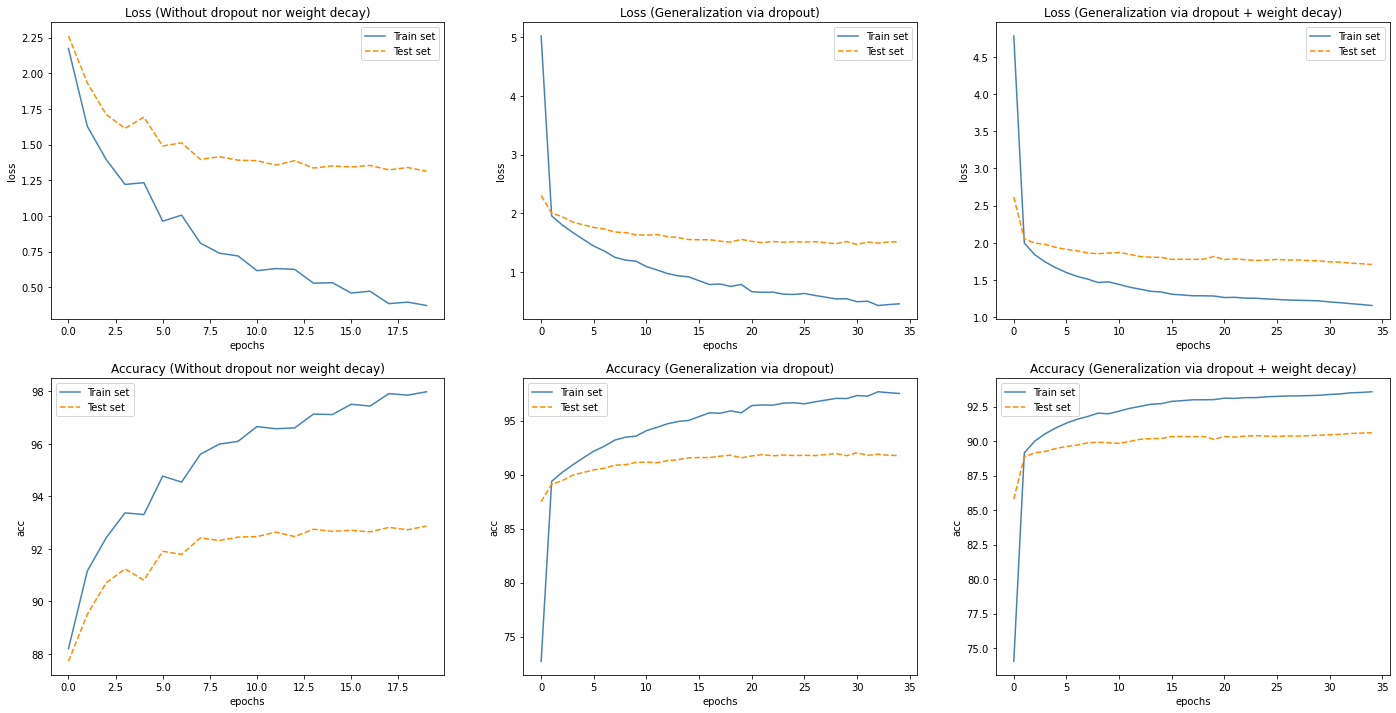

In [ ]:
# Models to evaluate generalization

F = 784
C = 10

model1 = FFNN(F, [1024, 512, 256], [relu, relu, relu], C, keep_prob=[1.0, 1.0, 1.0, 1.0])  
optimizer1 = SGD(model1.parameters(), lr=0.0001, beta=0.0)

model2 = FFNN(F, [1024, 512, 256], [relu, relu, relu], C, keep_prob=[1.0, 0.7, 0.8, 1.0])  
optimizer2 = SGD(model2.parameters(), lr=0.0001, beta=0.0)

model3 = FFNN(F, [1024, 512, 256], [relu, relu, relu], C, keep_prob=[1.0, 0.7, 0.8, 1.0])  
optimizer3 = SGD(model3.parameters(), lr=0.0001, beta=0.0001)

with torch.no_grad():
  loss1, acc1, loss1_test, acc1_test = entrenar_FFNN(model1, train_set, test_set, optimizer1, epochs=20, batch_size=128)
  loss2, acc2, loss2_test, acc2_test = entrenar_FFNN(model2, train_set, test_set, optimizer2, epochs=35, batch_size=128)
  loss3, acc3, loss3_test, acc3_test = entrenar_FFNN(model3, train_set, test_set, optimizer3, epochs=35, batch_size=128)

loss_train = [loss1, loss2, loss3]
loss_test = [loss1_test, loss2_test, loss3_test]
accuracy_train = [acc1, acc2, acc3]
accuracy_test = [acc1_test, acc2_test, acc3_test]
models_desc = ['Without dropout nor weight decay', 'Generalization via dropout', 'Generalization via dropout + weight decay']
plot_models(loss_train, accuracy_train, loss_test, accuracy_test, models_desc)

Se puede notar que al no usar métodos de generalización, los aciertos obtenidos en los conjuntos de entrenamiento y de prueba difieren en una cantidad mayor a que cuando se utiliza generalización mediante **dropout** y **weight decay** en conjunto. Sin embargo, en este último caso, el acierto es peor, lo cual tiene sentido ya que al hacer generalización se le hace más dificil a la red aprender, lo cual se puede compensar añadiendo más épocas de entrenamiento.

# Parte 2: Optimización

## 2a) Inicialización de Xavier/He

Para los test de esta parte vamos a necesitar que modifiques tu código para que se pueda entregar valores predeterminados de `r`. Ahora tu código para las inicializaciones debe ser: `xavier_init(first_dim, second_dim, r=None)`, `he_init(first_dim, second_dim, r=None)`.

In [ ]:
def xavier_init(first_dim, second_dim, r=None):
  return r * torch.rsqrt(torch.tensor(first_dim).float())

def he_init(first_dim, second_dim, r=None):
  return torch.tensor(r * torch.sqrt(torch.div(2, torch.tensor(first_dim).float())))

In [ ]:
# Tests del API del curso
r_xavier = corrector.get_test_data(homework=3, question="2a", test=1, token=token)
r_he = corrector.get_test_data(homework=3, question="2a", test=2, token=token)

w_xavier = xavier_init(50, 50, torch.tensor(r_xavier))
w_he = he_init(50, 50, torch.tensor(r_he))

corrector.submit(homework=3, question="2a", test=1, token=token, answer=w_xavier)
corrector.submit(homework=3, question="2a", test=2, token=token, answer=w_he)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Correct Test!
Correct Test!


## 2b) Descenso de gradiente con momentum

In [ ]:
# Tu código debiera continuar así

class SGD():
  
  def __init__(self, parameters, lr, beta=0, momentum=0):
    self.params = [p for p in parameters if p is not None]
    self.v = [torch.zeros_like(p) for p in self.params if p is not None]
    self.lr = lr
    self.beta = beta
    self.momentum = momentum
  
  def step(self):
    for i, (p, v) in enumerate(zip(self.params, self.v)):
      if p.is_cuda:
        v = v.to('cuda')
      if p.dim() > 1:
        self.v[i] = self.momentum * v - self.lr * p.grad
        p_r = p.data.clone()
        p.data = p_r*(1 - self.beta) + self.v[i]
      else:
        p.data -= p.grad * self.lr


In [ ]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="2b", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = SGD([weight], lr=0.1, momentum=0.9)
optimizer.step()

# Submit
corrector.submit(homework=3, question="2b", test=1, token=token, answer=weight)
optimizer.step()
corrector.submit(homework=3, question="2b", test=2, token=token, answer=weight)

Correct Test!
Correct Test!


## 2c) RMSProp

In [ ]:
class RMSProp():
  
  def __init__(self, parameters, lr=0.001, beta=0.9, epsilon=1e-8):
    self.params = [p for p in parameters if p is not None]
    self.lr = lr
    self.beta = beta
    self.epsilon = epsilon
    self.s = [torch.zeros_like(p) for p in self.params if p is not None]
  
  def step(self):
    for i, (p, s) in enumerate(zip(self.params, self.s)):
      if p.is_cuda:
        s = s.to('cuda')
      if p.dim() > 1:
        self.s[i] = self.beta * s + (1 - self.beta) * (p.grad * p.grad)
        p_r = p.data.clone()
        p.data = p.data - self.lr * torch.reciprocal(torch.sqrt(self.s[i]) + self.epsilon) * p.grad
      else:
        p.data -= p.grad * self.lr

In [ ]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="2c", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = RMSProp([weight], lr=0.001, beta=0.9, epsilon=1e-8)
optimizer.step()

# Submit
corrector.submit(homework=3, question="2c", test=1, token=token, answer=weight)
optimizer.step()
corrector.submit(homework=3, question="2c", test=2, token=token, answer=weight)

Correct Test!
Correct Test!


## 2d) Adam

In [ ]:
class Adam():
  
  def __init__(self, parameters, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    self.params = [p for p in parameters if p is not None]
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.p = [torch.zeros_like(p) for p in self.params if p is not None]
    self.s = [torch.zeros_like(p) for p in self.params if p is not None]
    self.n = 1
  
  def step(self):
    for i, (p, pd, sd) in enumerate(zip(self.params, self.p, self.s)):
      if p.is_cuda:
        pd = pd.to('cuda')
        sd = sd.to('cuda')
      if p.dim() > 1:
        self.p[i] = self.beta1 * pd + (1 - self.beta1) * (p.grad)
        self.s[i] = self.beta2 * sd + (1 - self.beta2) * (p.grad * p.grad)
        pdm = torch.div(self.p[i], 1 - self.beta1 ** self.n)
        sdm = torch.div(self.s[i], 1 - self.beta2 ** self.n)
        self.n += 1
        p_r = p.data.clone()
        p.data = p.data - self.lr * torch.reciprocal(torch.sqrt(sdm) + self.epsilon) * pdm
      else:
        p.data -= p.grad * self.lr

In [ ]:
# Tests del API del curso
weight, grad = corrector.get_test_data(homework=3, question="2d", test=1, token=token)

weight = torch.tensor(weight, requires_grad=True)
weight.grad = torch.tensor(grad)

optimizer = Adam([weight], lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8)
optimizer.step()

# Submit
corrector.submit(homework=3, question="2d", test=1, token=token, answer=weight)
optimizer.step()
corrector.submit_check_some(homework=3, question="2d", tests=[2, 3], token=token,
                            answer_dict={2: weight, 3: weight}, required_number=1)

Correct Test!
Correct Test!


## 2e) Entrenamiento en MNIST 

Usa tu red neuronal para entrenar con los datos de MNIST y compara cómo cambian las curvas de entrenamiento dependiendo de factores como la inicialización y los algoritmos que utilices. Presenta al menos dos gráficos en donde compares. Por ejemplo, puedes presentar uno que para la misma estrategia de inicialización, los tres algoritmos de optimización para varias épocas y cómo evoluciona la pérdida y el acierto. En cada caso comenta que conclusiones puedes sacar. Algunos ejemplos de preguntas que podrías tratar de responder son:
* ¿cómo afecta el algoritmo de optimización al tiempo de convergencia de la red para los datos de entrenamiento?
* ¿cómo afecta el algoritmo de optimización en el acierto alcanzado por la red en los datos de prueba?
* Si haces la parte opcional de Batch Normalization, puedes también preguntarte cosas como si aplicar, o no, BN afecta a todos los algoritmos de optimización por igual.

In [ ]:
def get_init_weights(shape, init_fun):
  W = torch.randn(shape)
  if init_fun is not None:
    return torch.nn.Parameter(init_fun(shape[0], shape[1], W))
  return torch.nn.Parameter(W)

def create_dropout_mask(x, prob):
    m = torch.distributions.Bernoulli(torch.tensor([prob]))
    mask = torch.div(m.sample(sample_shape=torch.Size([1,x.shape[1]])).view(-1,x.shape[1]).repeat(x.shape[0], 1), prob)
    return mask


class FFNN(torch.nn.Module):
  
  def __init__(self, F, l_h, l_a, C, keep_prob, init_fun=None, l_a_params=None):
    super(FFNN, self).__init__()
       
    sizes = [F] + l_h + [C]
    self.Ws = torch.nn.ParameterList([get_init_weights((sizes[i], sizes[i+1]), init_fun) for i in range(len(sizes)-1)])
    self.bs = torch.nn.ParameterList([torch.nn.Parameter(torch.zeros(h)) for h in sizes[1:]])
    self.fs = l_a
    self.keep_prob = keep_prob
    if l_a_params is not None:
      self.fs_ps_mask = [torch.nn.Parameter(torch.tensor(p)) if p else None for p in l_a_params]
    else:
      self.fs_ps_mask = [None for _ in l_a]
    self.fs_ps = torch.nn.ParameterList([p for p in self.fs_ps_mask if p])
    
  @property
  def in_size(self):
    return self.Ws[0].shape[0]
    
  def load_weights(self, Ws, U, bs, c):
    self.Ws = torch.nn.ParameterList([torch.nn.Parameter(W) for W in Ws + [U]])
    self.bs = torch.nn.ParameterList([torch.nn.Parameter(b) for b in bs + [c]])
  
  def resumen(self):
    # Usa self.parameters() o self.named_parameters().
    for name, p in self.named_parameters():
      print('{}:\t{}'.format(name, p.size()))
    pass
  
  def forward(self, x, predict=False, output_layer=-1):
    self.cacheU = [] #, self.cacheH = [], []
    self.cacheM = []
    
    if predict:
      original_prob = self.keep_prob
      for i in range(len(self.keep_prob)):
        self.keep_prob[i] = 1.0
    
    counter = 0
    mask = create_dropout_mask(x, self.keep_prob[counter])
    if (x.is_cuda):
      mask = mask.to('cuda')
    self.cacheM.append(mask)
    x = torch.mul(x,mask)

    for W, b, f, p in zip(self.Ws[:-1], self.bs[:-1], self.fs, self.fs_ps_mask):
      x = torch.mm(x, W) + b
      self.cacheU.append(x)
      x = f(x, p.item()) if p else f(x)

      mask = create_dropout_mask(x, self.keep_prob[counter + 1])
      if (x.is_cuda):
        mask = mask.to('cuda')
      self.cacheM.append(mask)
      x = torch.mul(x,mask)

      # for the output_layer test
      if counter == output_layer:
        return x
      counter += 1

    return softmax(torch.mm(x, self.Ws[-1]) + self.bs[-1], dim=1)
  
  def backward(self, x, y, y_pred):
    current_grad =  (y_pred - y) / y.size(0)
    
    for i in range(len(self.Ws)-1, 0, -1):
      if self.fs_ps_mask[i-1] is None:
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1]).t() @ current_grad
      else:
        self.Ws[i].grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps_mask[i-1].item()).t()  @ current_grad
      self.bs[i].grad = current_grad.sum(dim=0)
      h_grad = torch.mul(current_grad @ self.Ws[i].t(), self.cacheM[i])

      if self.fs_ps_mask[i-1] is None:
        current_grad = self.fs[i-1](self.cacheU[i-1], gradient=True) * h_grad
      else:
        current_grad, p_grad = self.fs[i-1](self.cacheU[i-1], self.fs_ps_mask[i-1], gradient=True)
        current_grad *= h_grad
        self.fs_ps_mask[i-1].grad = (p_grad * h_grad).sum()
    
    self.Ws[0].grad = x.t() @ current_grad
    self.bs[0].grad = current_grad.sum(dim=0)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Epoch:035 Acc:99.38% Loss:0.1136 Tiempo/epoch:6.331s

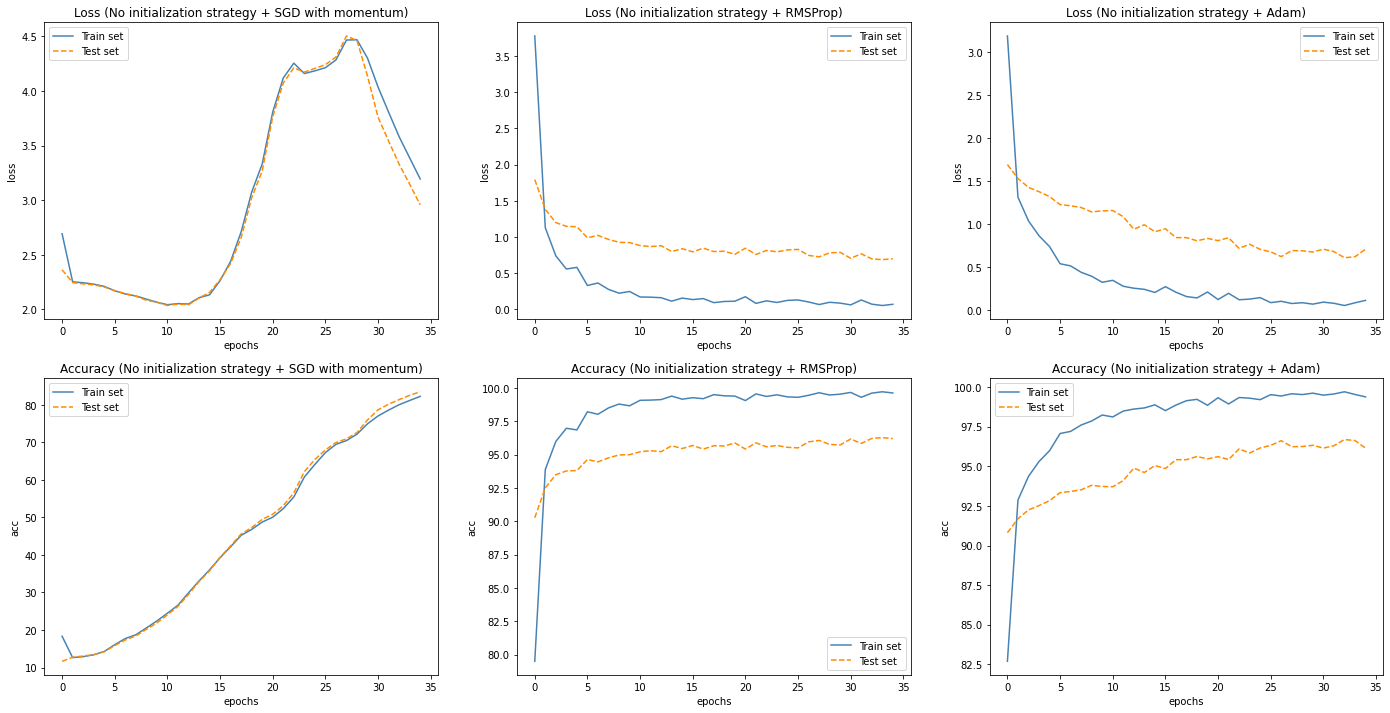

In [ ]:
# Models without initialization strategy

model4 = FFNN(F, [1024, 512, 256], [relu, relu, relu], C, keep_prob=[1.0, 0.7, 0.8, 1.0])  
optimizer4 = SGD(model4.parameters(), lr=0.0001, beta=0.0001, momentum=0.9)

model5 = FFNN(F, [1024, 512, 256], [relu, relu, relu], C, keep_prob=[1.0, 0.7, 0.8, 1.0])  
optimizer5 = RMSProp(model5.parameters())

model6 = FFNN(F, [1024, 512, 256], [relu, relu, relu], C, keep_prob=[1.0, 0.7, 0.8, 1.0])  
optimizer6 = Adam(model6.parameters())

with torch.no_grad():
  loss4, acc4, loss4_test, acc4_test = entrenar_FFNN(model4, train_set, test_set, optimizer4, epochs=35, batch_size=128)
  loss5, acc5, loss5_test, acc5_test = entrenar_FFNN(model5, train_set, test_set, optimizer5, epochs=35, batch_size=128)
  loss6, acc6, loss6_test, acc6_test = entrenar_FFNN(model6, train_set, test_set, optimizer6, epochs=35, batch_size=128)

loss_train_no_init = [loss4, loss5, loss6]
loss_test_no_init = [loss4_test, loss5_test, loss6_test]
accuracy_train_no_init = [acc4, acc5, acc6]
accuracy_test_no_init = [acc4_test, acc5_test, acc6_test]
models_desc_no_init = ['No initialization strategy + SGD with momentum', 'No initialization strategy + RMSProp', 'No initialization strategy + Adam']
plot_models(loss_train_no_init, accuracy_train_no_init, loss_test_no_init, accuracy_test_no_init, models_desc_no_init)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Epoch:035 Acc:99.84% Loss:0.0281 Tiempo/epoch:6.297s

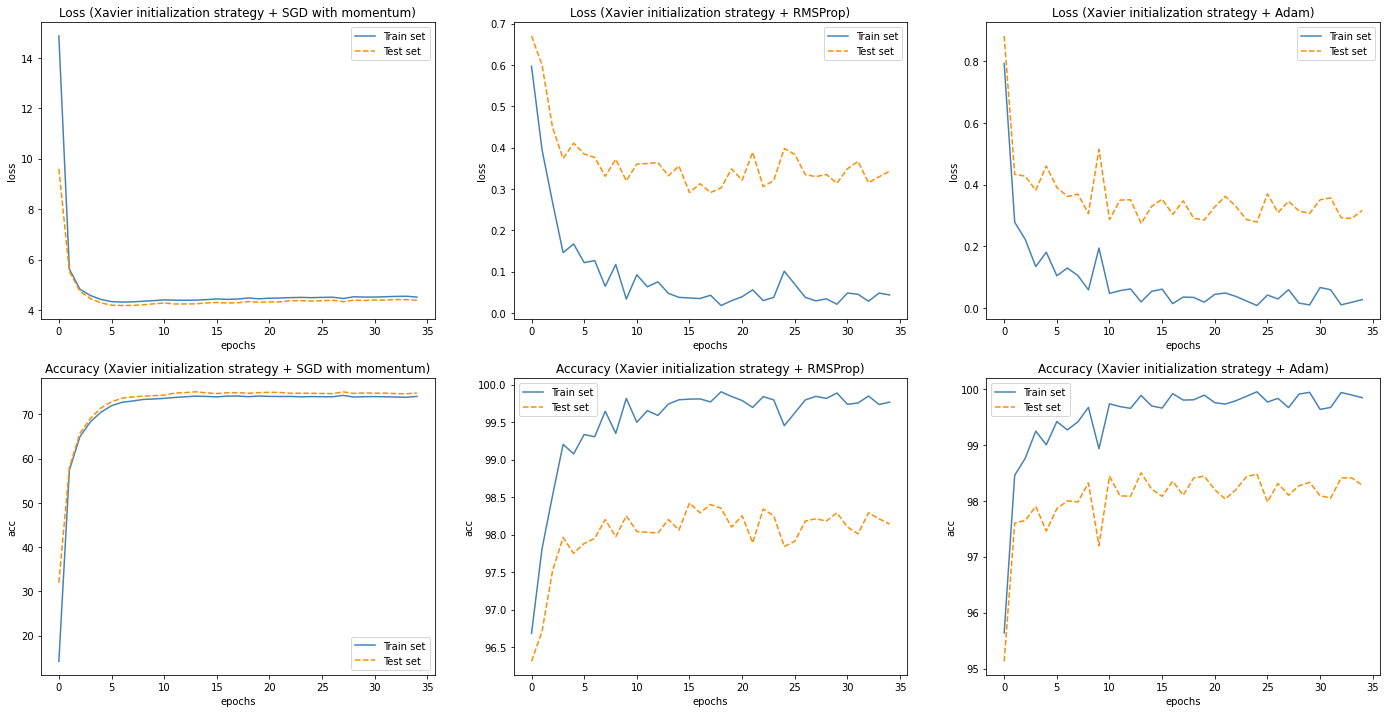

In [ ]:
# Models with Xavier initialization strategy 

model7 = FFNN(F, [1024, 512, 256], [relu, relu, relu], C, keep_prob=[1.0, 0.7, 0.8, 1.0], init_fun=xavier_init)  
optimizer7 = SGD(model7.parameters(), lr=0.0001, beta=0.0001, momentum=0.9)

model8 = FFNN(F, [1024, 512, 256], [relu, relu, relu], C, keep_prob=[1.0, 0.7, 0.8, 1.0], init_fun=xavier_init)  
optimizer8 = RMSProp(model8.parameters())

model9 = FFNN(F, [1024, 512, 256], [relu, relu, relu], C, keep_prob=[1.0, 0.7, 0.8, 1.0], init_fun=xavier_init)  
optimizer9 = Adam(model9.parameters())

with torch.no_grad():
  loss7, acc7, loss7_test, acc7_test = entrenar_FFNN(model7, train_set, test_set, optimizer7, epochs=35, batch_size=128)
  loss8, acc8, loss8_test, acc8_test = entrenar_FFNN(model8, train_set, test_set, optimizer8, epochs=35, batch_size=128)
  loss9, acc9, loss9_test, acc9_test = entrenar_FFNN(model9, train_set, test_set, optimizer9, epochs=35, batch_size=128)

loss_train_xavier_init = [loss7, loss8, loss9]
loss_test_xavier_init = [loss7_test, loss8_test, loss9_test]
accuracy_train_xavier_init = [acc7, acc8, acc9]
accuracy_test_xavier_init = [acc7_test, acc8_test, acc9_test]
models_desc_xavier_init = ['Xavier initialization strategy + SGD with momentum', 'Xavier initialization strategy + RMSProp', 'Xavier initialization strategy + Adam']
plot_models(loss_train_xavier_init, accuracy_train_xavier_init, loss_test_xavier_init, accuracy_test_xavier_init, models_desc_xavier_init)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Epoch:035 Acc:99.88% Loss:0.0210 Tiempo/epoch:6.249s

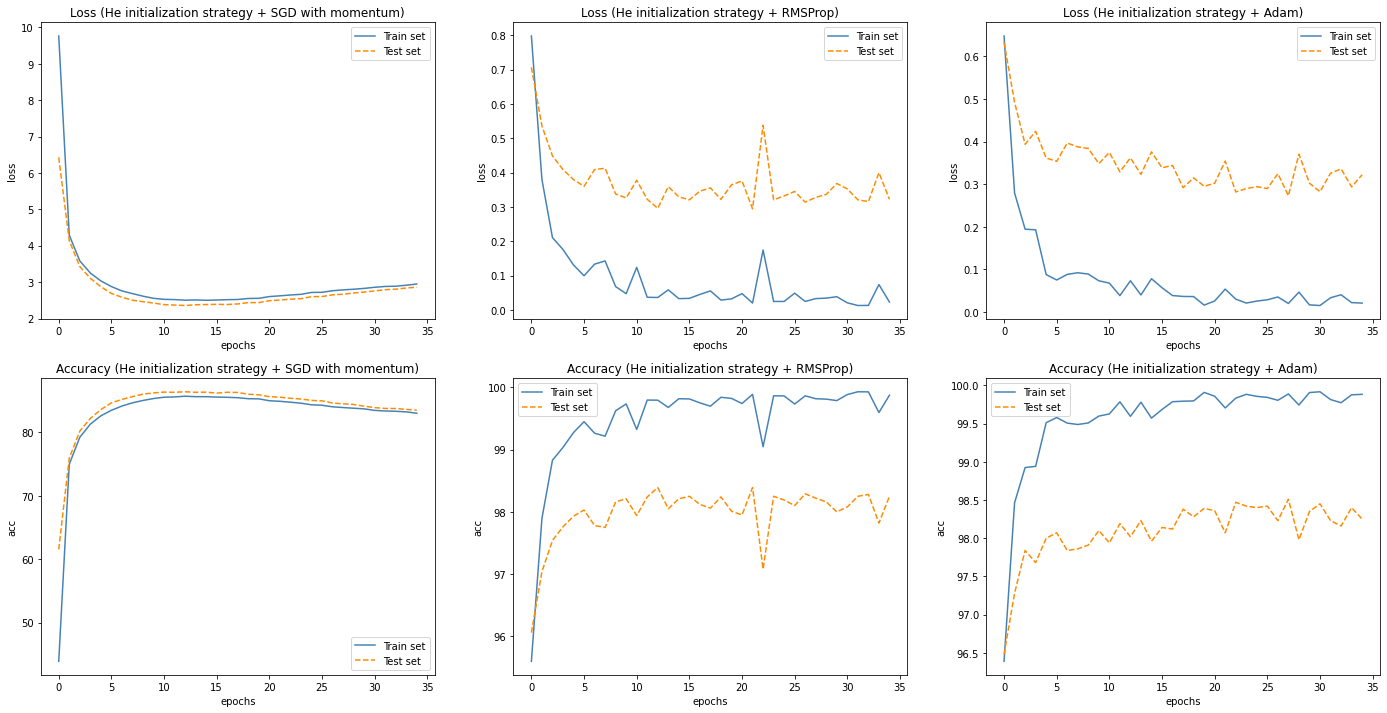

In [ ]:
# Models with He initialization strategy 

model10 = FFNN(F, [1024, 512, 256], [relu, relu, relu], C, keep_prob=[1.0, 0.7, 0.8, 1.0], init_fun=he_init)  
optimizer10 = SGD(model10.parameters(), lr=0.0001, beta=0.0001, momentum=0.9)

model11 = FFNN(F, [1024, 512, 256], [relu, relu, relu], C, keep_prob=[1.0, 0.7, 0.8, 1.0], init_fun=he_init)  
optimizer11 = RMSProp(model11.parameters())

model12 = FFNN(F, [1024, 512, 256], [relu, relu, relu], C, keep_prob=[1.0, 0.7, 0.8, 1.0], init_fun=he_init)  
optimizer12 = Adam(model12.parameters())

with torch.no_grad():
  loss10, acc10, loss10_test, acc10_test = entrenar_FFNN(model10, train_set, test_set, optimizer10, epochs=35, batch_size=128)
  loss11, acc11, loss11_test, acc11_test = entrenar_FFNN(model11, train_set, test_set, optimizer11, epochs=35, batch_size=128)
  loss12, acc12, loss12_test, acc12_test = entrenar_FFNN(model12, train_set, test_set, optimizer12, epochs=35, batch_size=128)

loss_train_he_init = [loss10, loss11, loss12]
loss_test_he_init = [loss10_test, loss11_test, loss12_test]
accuracy_train_he_init = [acc10, acc11, acc12]
accuracy_test_he_init = [acc10_test, acc11_test, acc12_test]
models_desc_he_init = ['He initialization strategy + SGD with momentum', 'He initialization strategy + RMSProp', 'He initialization strategy + Adam']
plot_models(loss_train_he_init, accuracy_train_he_init, loss_test_he_init, accuracy_test_he_init, models_desc_he_init)

Se puede apreciar que el algoritmo de optimización tiene un gran efecto en términos del tiempo de convergencia para los datos de entrenamiento independiente del método de inicialización, al tener valores de *loss* bajísimos ya en la época 5 utilizando **RMSProp** y **Adam** en comparación a **SGD con momentum**.

En cuanto al acierto alcanzado para los datos de prueba, se observa que con la estrategia de inicializacion **He** se logra un máximo de 85% mediante **SGD con momentum**, bastante inferior con respecto a los otros algoritmos de optimización. Con respecto a la estrategia de inicialización **Xavier** se puede apreciar lo mismo. Sin embargo, si bien el modelo que utiliza **SGD con momentum** tiene un peor acierto que sus contrapartes para la época 35 cuando no se utiliza una estrategia de inicialización, da la impresión de que puede mejorar bastante aumentando la cantidad de épocas.

# Parte 3 (Opcional): Batch Normalization

In [ ]:
# Tu código debiera continuar como sigue

class FFNN():
  def __init__(self, F, l_h, l_a, C, keep_prob=None, bn=None):
    # debes crear los parámetros necesarios para las capas de
    # batch normalizacion
    pass
  
  def forward(x, predict=False):
    # debes modificar esta función para considerar las capas para las que se
    # usará batch normalization
    # también debes preocuparte de guardar los datos estadísticos que se
    # usaran en tiempo de test (predict=True)
    pass
  
  def backward(x,y,y_pred):
    # computar acá todos los gradientes considerando las capas de 
    # batch normalization
    # no olvides considerar los nuevos parámetros entrenables.
    pass